In [149]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [122]:
def parse_data(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [123]:
def plot_data(data, label_x, label_y, label_pos, label_neg, axes=None):
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], c='b', label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='r', label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

### Logistic regression

In [124]:
data = parse_data('data/ex2data1.txt', ',')

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [125]:
X = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]]

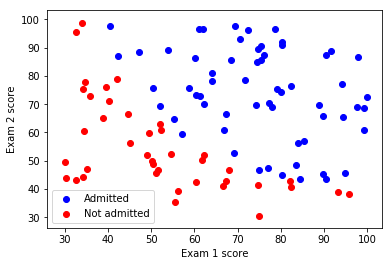

In [126]:
plot_data(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

In [127]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [128]:
def cost(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
               
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [129]:
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1/m)*X.T.dot(h-y)

    return(grad.flatten())

In [130]:
initial_theta = np.zeros(X.shape[1])
cost = cost(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost:', cost)
print('Grad:', grad)

Cost: 0.6931471805599452
Grad: [ -0.1        -12.00921659 -11.26284221]


#### Predict

In [131]:
def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [132]:
# Prediction (Exam 1 score = 90, Exam 2 score = 85)
sigmoid(np.array([1, 90, 85]).dot(res.x.T))

0.9999731333921332

In [133]:
prediction = predict(res.x, X) 
print(100*sum(prediction == y.ravel())/prediction.size,"%") 
#Prediction accuracy

89.0 %


#### Plot Regression

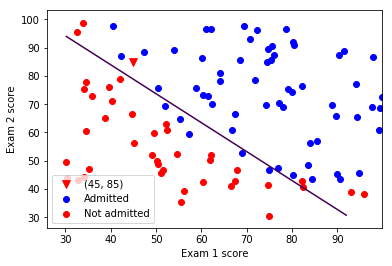

In [134]:
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plot_data(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, 0.5);

### Regularization

In [135]:
data2 = parse_data('data/ex2data2.txt', ',')

Dimensions:  (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [136]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

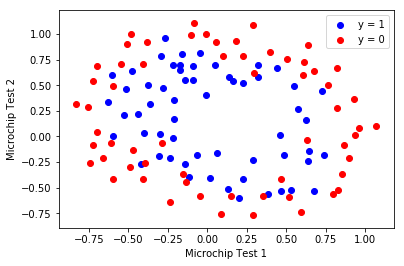

In [137]:
plot_data(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

#### Polynomials

In [138]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

(118, 28)

In [139]:
def cost_reg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    return(J[0])

In [140]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [141]:
initial_theta = np.zeros(XX.shape[1])
cost_reg(initial_theta, 1, XX, y)

0.6931471805599453

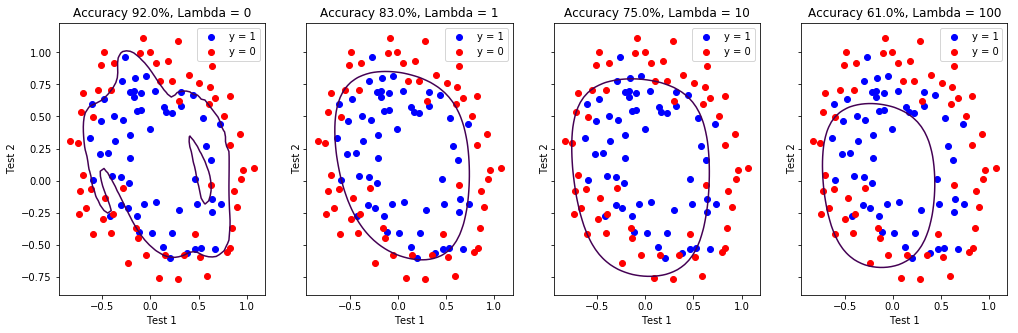

In [151]:
fig, axes = plt.subplots(1,4, sharey = True, figsize=(17,5))

for i, C in enumerate([0, 1, 10, 100]):
    # Learn Parameters
    res2 = minimize(cost_reg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    
    # Prediction Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Create Plot
    plot_data(data2, 'Test 1', 'Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Draw Plot for each regularization
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5]);       
    axes.flatten()[i].set_title('Accuracy {}%, Lambda = {}'.format(np.round(accuracy), C))